In [1]:
#!pip install pmdarima

In [53]:
!pip install tensorflow yfinance numpy pandas matplotlib scikit-learn statsmodels keras-tuner

# Create a function for forecasting
This function forecasts the Open, High, Low, or Close prices of a stock using linear regression and exponential smoothing models. It is designed to work modularly for each type of price by accepting two arguments: `stock_data` and `price_type`.

### Parameters:
- `stock_data`: A DataFrame containing the historical stock data fetched using the `yfinance` library.
- `price_type`: A string indicating the type of price to forecast. Valid options are "Open", "High", "Low", and "Close".

### Workflow:

1. **Rolling Averages Calculation:**
   - For the specified `price_type`, it calculates the 6-day and 25-day rolling averages and adds them as new columns to the `stock_data` DataFrame.

2. **Data Splitting:**
   - The data is split into training and test sets based on a predefined split date. The training set is used to fit the models, while the test set is used for forecasting.

3. **Linear Regression Model:**
   - Prepares training and test data specifically for the linear regression model, focusing on the rolling averages as features.
   - Fits the linear regression model on the training data and predicts the specified price type for the test set.

4. **Exponential Smoothing Model:**
   - Utilizes the Exponential Smoothing model from the `statsmodels` library, configured to account for both trend and seasonality.
   - Fits the model on the training data and forecasts the specified price type for the test set.

5. **Performance Metrics:**
   - Calculates and prints the Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) for the exponential smoothing model's forecasts.

6. **Visualization:**
   - Generates plots to visually compare the actual vs. predicted prices for both the linear regression and exponential smoothing forecasts. This includes the training data, actual test data, and the predictions from both models.

### Usage:

To forecast different price types (Open, High, Low, Close), call the `forecast_price` function with the `stock_data` DataFrame and the desired `price_type` as arguments. For example:



In [17]:
# Import necessary libraries
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def forecast_price(stock_data, price_type):
    # Calculate rolling averages for the specified price type
    stock_data[f'6_day_avg_{price_type}'] = stock_data[price_type].rolling(window=6, min_periods=1).mean()
    stock_data[f'25_day_avg_{price_type}'] = stock_data[price_type].rolling(window=25, min_periods=1).mean()

    # Split the data into training and test sets
    split_date = pd.to_datetime('2023-10-01')
    train = stock_data[:split_date].copy()  # Explicitly copying here as well if train will be modified
    test = stock_data[split_date:].copy()

    # Prepare the training and test data
    X_train_lr = train[[f'6_day_avg_{price_type}', f'25_day_avg_{price_type}']]
    y_train_lr = train[price_type]
    X_test_lr = test[[f'6_day_avg_{price_type}', f'25_day_avg_{price_type}']]

    # Fit and predict with linear regression
    model_lr = LinearRegression()
    model_lr.fit(X_train_lr, y_train_lr)
    test[f'{price_type}_Predicted_LR'] = model_lr.predict(X_test_lr)

    # Fit and forecast with exponential smoothing
    es_model = ExponentialSmoothing(train[price_type], trend='add', seasonal='add', seasonal_periods=12)
    fit_es_model = es_model.fit()
    test[f'{price_type}_Predicted_ES'] = fit_es_model.forecast(len(test))

    # Calculate and print performance metrics
    mae_es = mean_absolute_error(test[price_type], test[f'{price_type}_Predicted_ES'])
    mse_es = mean_squared_error(test[price_type], test[f'{price_type}_Predicted_ES'])
    rmse_es = np.sqrt(mse_es)

    print(f"\n{price_type} - Exponential Smoothing Metrics:")
    print(f"Mean Absolute Error (MAE): {mae_es:.2f}")
    print(f"Mean Squared Error (MSE): {mse_es:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_es:.2f}")

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train[price_type], label='Train Data')
    plt.plot(test.index, test[price_type], label=f'Actual Test Data - {price_type}')
    plt.plot(test.index, test[f'{price_type}_Predicted_LR'], label=f'Predicted Test Data (LR) - {price_type}', linestyle='--')
    plt.plot(test.index, test[f'{price_type}_Predicted_ES'], label=f'Predicted Test Data (ES) - {price_type}', linestyle='-.')
    plt.title(f'{price_type} Forecasting')
    plt.xlabel('Date')
    plt.ylabel(f'{price_type} Price')
    plt.legend()
    plt.show()


# Forecast OHLC

[*********************100%%**********************]  1 of 1 completed

Open - Exponential Smoothing Metrics:
Mean Absolute Error (MAE): 21.06
Mean Squared Error (MSE): 684.61
Root Mean Squared Error (RMSE): 26.16


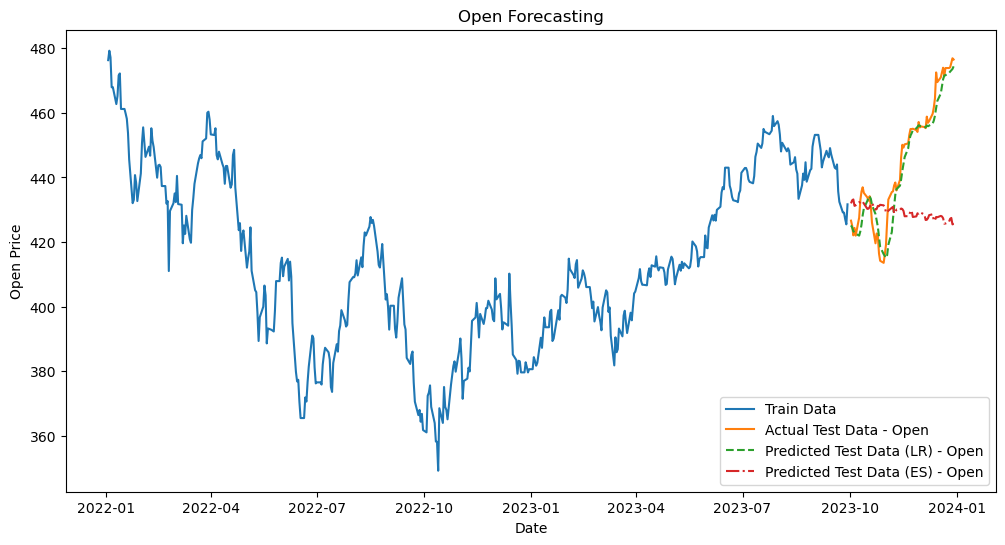


High - Exponential Smoothing Metrics:
Mean Absolute Error (MAE): 21.93
Mean Squared Error (MSE): 752.86
Root Mean Squared Error (RMSE): 27.44


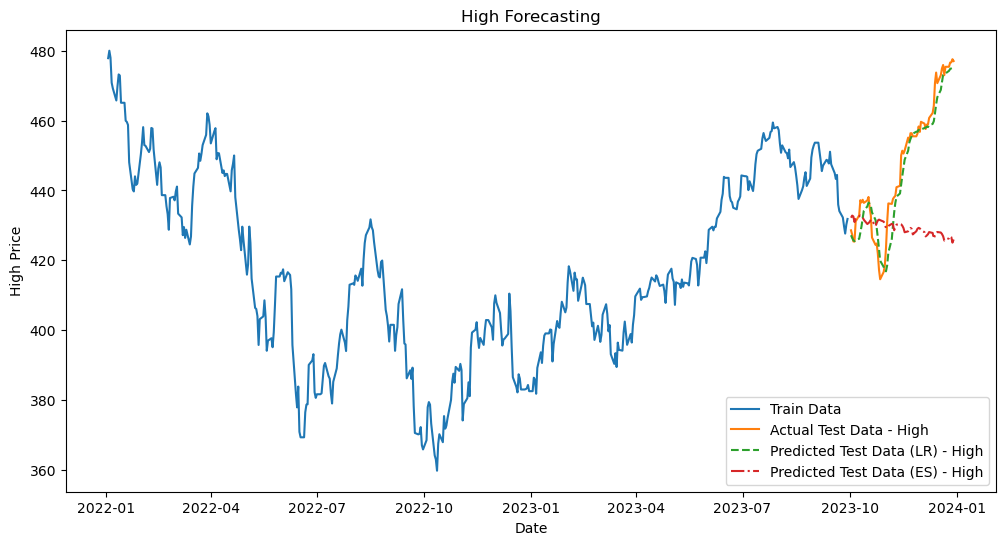


Low - Exponential Smoothing Metrics:
Mean Absolute Error (MAE): 23.77
Mean Squared Error (MSE): 874.43
Root Mean Squared Error (RMSE): 29.57


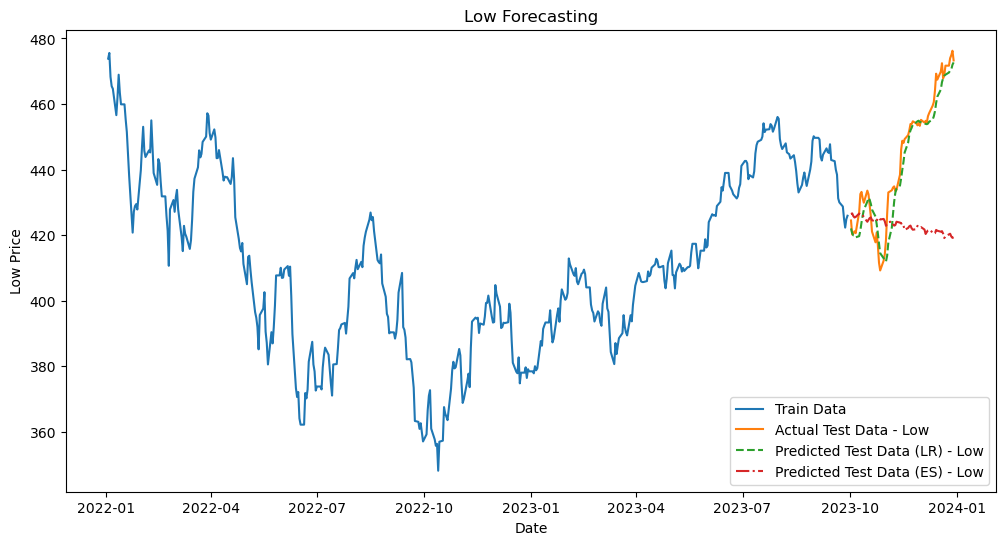


Close - Exponential Smoothing Metrics:
Mean Absolute Error (MAE): 24.21
Mean Squared Error (MSE): 911.82
Root Mean Squared Error (RMSE): 30.20


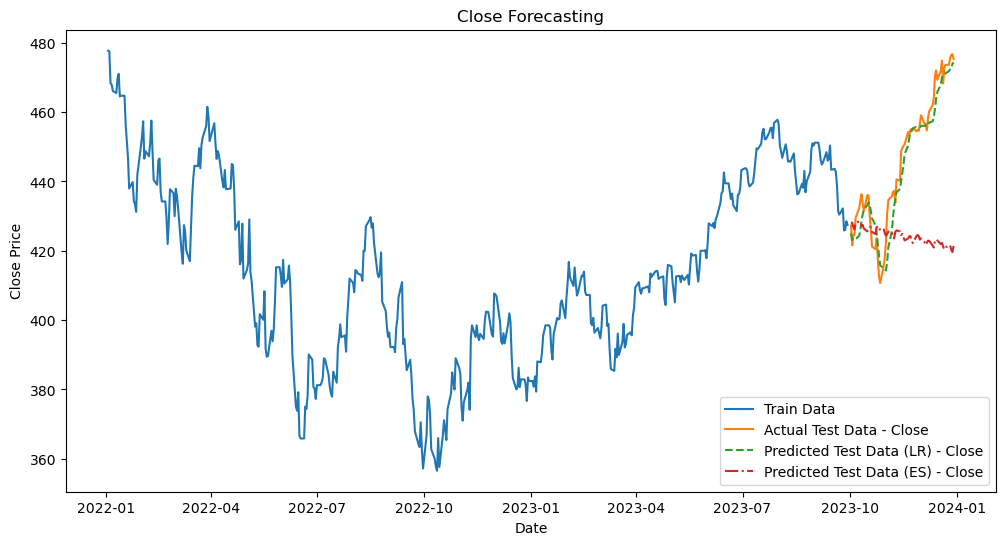

In [26]:
# Data Acquisition
stock_data = yf.download('SPY', start='2022-01-01', end='2024-01-01')
stock_data.sort_index(ascending=True, inplace=True)

# Ensure proper DatetimeIndex with frequency for time series analysis
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.asfreq('B', method='ffill')

# Forecast for each price type
for price_type in ['Open', 'High', 'Low', 'Close']:
    forecast_price(stock_data, price_type)

# Forecasting with LSTM Model & Hyperparameter Tuning

This notebook outlines a method for forecasting stock prices using a Long Short-Term Memory (LSTM) neural network, which is a type of recurrent neural network (RNN) suitable for time series prediction. The approach includes preprocessing historical stock data, scaling features, creating input sequences for the LSTM, training the model, and visualizing predictions against actual prices.

## Data Acquisition and Preprocessing

The `download_stock_data` function retrieves historical stock data for a specified ticker symbol, date range, and frequency using the `yfinance` library. It ensures that there are no gaps in the data by filling missing values for non-trading days.

## Feature Scaling

To ensure our LSTM model receives data in a scale that neural networks find easy to process, we apply Min-Max Scaling to the input features. The `MinMaxScaler` from the scikit-learn library is used to transform the data so that it fits within a given range, typically [0, 1]. The scaling process is crucial for the convergence of the neural network during training and can significantly impact the model's performance.

### `scale_data` Function

The `scale_data` function takes a dataset as input and returns a fitted `MinMaxScaler` object along with the scaled dataset. This scaler can later be used to inverse-transform the predictions to their original scale, which is important for interpretability of the results.

#### Parameters:
- `data`: The input features that we want to scale.

#### Returns:
- `scaler`: The `MinMaxScaler` instance fit to the input data.
- `scaled_data`: The input data transformed to the scale [0, 1].

#### Usage:

The function is typically called with the feature data as follows:

```python
scaler, scaled_data = scale_data(stock_data[features].values)
```

## Sequence Creation for Time Series Forecasting

Time series forecasting with LSTM networks requires the input data to be structured as sequences. The `create_sequences` function transforms a time series data array into sequences of a specified length to be used as input for LSTM models.

### `create_sequences` Function

#### Parameters:
- `data`: The array of time series data.
- `seq_length`: The length of the look-back period for creating sequences.

#### Returns:
- `xs`: The input sequences for the model.
- `ys`: The target values for each sequence.

### LSTM Model Building and Training

LSTM (Long Short-Term Memory) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. The `build_and_train_model` function constructs an LSTM model and trains it on the provided training data.

#### Parameters:
- `X_train`: Input features for training the model.
- `y_train`: Target outputs for training the model.
- `seq_length`: Number of time steps in each input sequence.
- `num_features`: Number of features in the input data.
- `epochs`: Number of epochs to train the model.
- `batch_size`: Size of batches to use when training the model.

#### Returns:
- `model`: The trained LSTM model.

### Performance Metrics Calculation

To evaluate the forecasting model, we calculate various metrics to understand its accuracy and performance. The `calculate_metrics` function computes the Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

#### Parameters:
- `y_true`: The actual observed values.
- `y_pred`: The predicted values by the model.

#### Returns:
- `mae`: Mean Absolute Error.
- `mse`: Mean Squared Error.
- `rmse`: Root Mean Squared Error.

### Forecast Visualization

Visual representation of forecasts can help in understanding how well the model predictions align with the actual data. The `plot_forecasts` function generates interactive plots using Plotly to compare the actual and predicted values.

#### Parameters:
- `stock_data`: Original DataFrame containing the stock price data.
- `predicted_values`: Predicted values from the model.
- `y_test`: Actual values corresponding to the predictions.
- `seq_length`: Length of the input sequences.
- `split_idx`: Index to split the data into training and test sets.
- `scaler`: The MinMaxScaler used to scale the data.

#### Visualization:
- The function creates a line plot for each stock price feature, displaying both actual and predicted values.

### Full Forecasting and Plotting Workflow

The `forecast_and_plot` function brings together all the steps required for forecasting stock prices using the LSTM model, from data scaling and sequence creation to model training and visualization of predictions.

#### Parameters:
- `stock_data`: DataFrame containing historical stock data.
- `features`: List of features to use for forecasting.
- `seq_length`: Length of the input sequences for the LSTM model.

#### Execution Workflow:
- The function first scales the data, creates sequences, and splits the data into training and test sets.
- It then builds, trains, and evaluates the LSTM model.
- Finally, it visualizes the forecasts alongside the actual data for comparison.



In [18]:
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = stock_data.sort_index().asfreq('B', method='ffill')
    stock_data.index = pd.to_datetime(stock_data.index)
    return stock_data

# def scale_data(data):
#     scaler = MinMaxScaler()
#     scaled_data = scaler.fit_transform(data)
#     return scaler, scaled_data
def scale_data(data, feature_names):
    scaler = MinMaxScaler()
    # Convert the data to a DataFrame to ensure feature names are used
    data_df = pd.DataFrame(data, columns=feature_names)
    scaled_data = scaler.fit_transform(data_df)
    return scaler, scaled_data


def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

def build_and_train_model(X_train, y_train, seq_length, num_features, epochs, batch_size):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(50, activation='relu'),
        Dense(num_features)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

def plot_forecasts(stock_data, predicted_values, y_test, seq_length, split_idx, scaler):
    dates = stock_data.index[split_idx + seq_length:]
    predicted_prices = scaler.inverse_transform(predicted_values)
    actual_prices = scaler.inverse_transform(y_test)

    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.02)
    feature_names = ['Open', 'High', 'Low', 'Close']

    for i, feature in enumerate(feature_names):
        fig.add_trace(go.Scatter(x=dates, y=actual_prices[:, i], mode='lines', name=f'Actual {feature}'), row=i+1, col=1)
        fig.add_trace(go.Scatter(x=dates, y=predicted_prices[:, i], mode='lines', name=f'Predicted {feature}', line=dict(dash='dash')), row=i+1, col=1)

    fig.update_layout(height=800, width=1000, title_text="Stock Price Forecasting")
    fig.update_yaxes(title_text="<b>Price</b>")
    fig.update_xaxes(title_text="<b>Date</b>", row=4, col=1)
    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

def forecast_and_plot(stock_data, features, seq_length):
#     scaler, scaled_data = scale_data(stock_data[features].values)
    scaler, scaled_data = scale_data(stock_data[features].values, features)
    X, y = create_sequences(scaled_data, seq_length)
    split_idx = int(len(X) * 0.8)
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))
    
    model = build_and_train_model(X_train, y_train, seq_length, len(features), epochs=50, batch_size=32)
    predicted_values = model.predict(X_test)
    mae, mse, rmse = calculate_metrics(scaler.inverse_transform(y_test), scaler.inverse_transform(predicted_values))
    
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
    plot_forecasts(stock_data, predicted_values, y_test, seq_length, split_idx, scaler)

# Parameters and usage
ticker = 'SPY'
features = ['Open', 'High', 'Low', 'Close']
start_date = '2022-01-01'
end_date = '2024-03-11'
seq_length = 10

stock_data = download_stock_data(ticker, start_date, end_date)
forecast_and_plot(stock_data, features, seq_length)


[*********************100%%**********************]  1 of 1 completed
4/4 [==============================] - 0s 3ms/step
MAE: 3.531090463910786, MSE: 21.281319858086416, RMSE: 4.61316809341329


## Future Price Forecasting Function

The `forecast_future` function aims to predict future stock prices for a set number of days beyond the available data. It uses the last known data sequence as the input to the LSTM model to generate future predictions iteratively.

### Parameters:
- `stock_data`: The DataFrame containing historical stock data.
- `model`: The trained LSTM model for prediction.
- `scaler`: The scaler object used for normalizing the data.
- `seq_length`: The length of the input data sequence for the LSTM model.
- `num_features`: The number of features in the input data.
- `future_days`: The number of future days to predict.

### Process:
- The function first extracts the last sequence of data from the DataFrame.
- This sequence is then scaled and fed into the model to predict the next time step.
- This process is repeated for the specified number of `future_days`.
- Each new prediction is appended to the sequence for subsequent predictions.

### Returns:
- `future_predictions`: An array of predicted values for the specified number of days into the future.

## Complete Forecasting and Plotting Function

The `forecast_and_plot_complete` function encompasses the entire process of forecasting and visualization. It integrates data preparation, model training, evaluation, and future price prediction into a single workflow.

### Parameters:
- `ticker`: The stock symbol for the company being analyzed.
- `features`: The list of stock attributes to use for prediction, such as 'Open', 'High', 'Low', 'Close'.
- `start_date`: The starting date for the historical data to download.
- `end_date`: The ending date for the historical data to download.
- `seq_length`: The length of the sequence to use in the LSTM model.
- `future_days`: The number of future days to forecast and visualize.

### Workflow:
- The function begins by downloading and scaling the stock data.
- It then creates sequences for the LSTM and splits the data into training and test sets.
- A LSTM model is built and trained with the training data.
- The model's performance is evaluated on the test data using metrics such as MAE, MSE, and RMSE.
- Future prices are forecasted using the entire available dataset.
- The future predictions are visualized as 'ghost candles' on a plot, providing a graphical representation of expected future price movements.

### Execution:
- Set the parameters for the stock symbol, features, date range, and sequence length.
- Call `forecast_and_plot_complete` to perform the forecasting and plotting.


In [19]:
def forecast_future(stock_data, model, scaler, seq_length, num_features, future_days=10):
    # Directly use the DataFrame without slicing it before the function call
    # Ensure stock_data is in the expected DataFrame format with columns
    
    # Extract the last sequence from the DataFrame
    last_sequence_df = stock_data.iloc[-seq_length:]  # Ensure this is a DataFrame slice
    last_sequence = scaler.transform(last_sequence_df[features])
    last_sequence = np.expand_dims(last_sequence, axis=0)
    
    future_predictions = []
    
    for _ in range(future_days):
        prediction = model.predict(last_sequence)
        future_predictions.append(prediction[0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[:, -1, :] = prediction

    future_predictions = np.array(future_predictions)
    future_predictions = scaler.inverse_transform(future_predictions)
    
    return future_predictions

def forecast_and_plot_complete(ticker, features, start_date, end_date, seq_length, future_days=10):
    stock_data = download_stock_data(ticker, start_date, end_date)
#     scaler, scaled_data = scale_data(stock_data[features].values)
    scaler, scaled_data = scale_data(stock_data[features].values, features)
    
    X, y = create_sequences(scaled_data, seq_length)
    split_idx = int(len(X) * 0.8)
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]
    
    num_features = len(features)
    X_train = X_train.reshape((X_train.shape[0], seq_length, num_features))
    X_test = X_test.reshape((X_test.shape[0], seq_length, num_features))
    
    model = build_and_train_model(X_train, y_train, seq_length, num_features, epochs=50, batch_size=32)
    
    # Generate predictions for the test set
    predicted_values_test = model.predict(X_test)
    mae, mse, rmse = calculate_metrics(scaler.inverse_transform(y_test), scaler.inverse_transform(predicted_values_test))
    print(f"Test Set - MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
    
    # Forecast future prices directly from the entire stock_data DataFrame
    future_predictions = forecast_future(stock_data, model, scaler, seq_length, num_features, future_days)
    plot_ghost_candles(future_predictions, '2024-03-11')

# Parameters
ticker = 'SPY'
features = ['Open', 'High', 'Low', 'Close']
start_date = '2022-03-11'
end_date = '2024-03-11'
seq_length = 10

# Execute the complete forecast and plot function
forecast_and_plot_complete(ticker, features, start_date, end_date, seq_length)

[*********************100%%**********************]  1 of 1 completed
4/4 [==============================] - 0s 3ms/step
Test Set - MAE: 10.584443546035917, MSE: 194.51482103463235, RMSE: 13.94685703069449
1/1 [==============================] - 0s 16ms/step
